<a href="https://colab.research.google.com/github/SharanyaBurra/Resume-Classifier/blob/main/Updated_COMP542_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STEP 1: IMPORTING LIBRARIES AND LOADING THE DATASET

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

!gdown "https://drive.google.com/uc?id=1t3EaoebZemUyhtUIpY1FfXOGB5XUBbQa"

# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from wordcloud import WordCloud

# Load the dataset
file_path = 'Updated_Resume_with_Class.csv'
resume_df = pd.read_csv(file_path)

# Initial cleaning
resume_df['Resume_str'] = resume_df['Resume_str'].fillna("")

In [ ]:
# Check if the dataset is loaded correctly
print(resume_df.info())  # Overview of dataset
print(resume_df.head())  # Preview the first few rows

# Confirm no missing values in 'Resume_str'
print("NaN values in 'Resume_str':", resume_df['Resume_str'].isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3446 entries, 0 to 3445
Columns: 170 entries, ID to Unnamed: 169
dtypes: object(170)
memory usage: 4.5+ MB
None
         ID                                         Resume_str  \
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...   
2  33176873           HR DIRECTOR       Summary      Over 2...   
3  27018550           HR SPECIALIST       Summary    Dedica...   
4  17812897           HR MANAGER         Skill Highlights  ...   

                                         Resume_html Category      Class  \
0  <div class="fontsize fontface vmargins hmargin...       HR  Unflagged   
1  <div class="fontsize fontface vmargins hmargin...       HR  Unflagged   
2  <div class="fontsize fontface vmargins hmargin...       HR  Unflagged   
3  <div class="fontsize fontface vmargins hmargin...       HR  Unflagged   
4  <div class="fontsize fontface vmargins hmargin...       HR

# STEP 2: DATA CLEANING

In [ ]:
# Drop columns with more than 95% NaN values
threshold = 0.95
resume_df = resume_df.loc[:, resume_df.isnull().mean() < threshold]

# Drop columns with a single unique value
resume_df = resume_df.loc[:, resume_df.nunique() > 1]

# Ensure the 'Class' column is correctly encoded (Flagged = 1, Unflagged = 0)
resume_df['Class'] = resume_df['Class'].map({'Unflagged': 0, 'Flagged': 1})

# Filter rows with exactly 5 non-NaN (valid) values, including 'Class'
valid_row_mask = resume_df.notna().sum(axis=1) == 5

# Apply the mask to filter rows
resume_df = resume_df[valid_row_mask]

# Fill missing values in the 'Category' column (if needed)
resume_df['Category'].fillna('Unknown', inplace=True)

# Drop any remaining rows where 'Class' is NaN
resume_df = resume_df.dropna(subset=['Class'])

# Convert 'Class' column to integers (in case NaNs were removed)
resume_df['Class'] = resume_df['Class'].astype(int)

# Verify the cleaned dataset
print(f"Shape after cleaning: {resume_df.shape}")
print("Remaining NaN values:", resume_df.isnull().sum().sum())
print("Unique values in 'Class':", resume_df['Class'].unique())
print(resume_df.head())


Shape after cleaning: (2458, 5)
Remaining NaN values: 0
Unique values in 'Class': [0 1]
         ID                                         Resume_str  \
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...   
2  33176873           HR DIRECTOR       Summary      Over 2...   
3  27018550           HR SPECIALIST       Summary    Dedica...   
4  17812897           HR MANAGER         Skill Highlights  ...   

                                         Resume_html Category  Class  
0  <div class="fontsize fontface vmargins hmargin...       HR      0  
1  <div class="fontsize fontface vmargins hmargin...       HR      0  
2  <div class="fontsize fontface vmargins hmargin...       HR      0  
3  <div class="fontsize fontface vmargins hmargin...       HR      0  
4  <div class="fontsize fontface vmargins hmargin...       HR      1  


<ipython-input-6-0e30669561d9>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  resume_df['Category'].fillna('Unknown', inplace=True)


# STEP 3: DATA VISUALIZATION

In [ ]:
print("Unique values in 'Class':", resume_df['Class'].unique())
print("Unique values in 'Category':", resume_df['Category'].unique())
print("Number of rows:", resume_df.shape[0])


Unique values in 'Class': [0 1]
Unique values in 'Category': ['HR' 'DESIGNER' 'INFORMATION-TECHNOLOGY' 'TEACHER' 'ADVOCATE'
 'BUSINESS-DEVELOPMENT' 'HEALTHCARE' 'FITNESS' 'AGRICULTURE' 'BPO' 'SALES'
 'CONSULTANT' 'DIGITAL-MEDIA' 'AUTOMOBILE' 'CHEF' 'FINANCE' 'APPAREL'
 'ENGINEERING' 'ACCOUNTANT' 'CONSTRUCTION' 'PUBLIC-RELATIONS' 'BANKING'
 'ARTS' 'AVIATION']
Number of rows: 2458


<ipython-input-8-f1891f170d17>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=resume_df, palette='viridis')


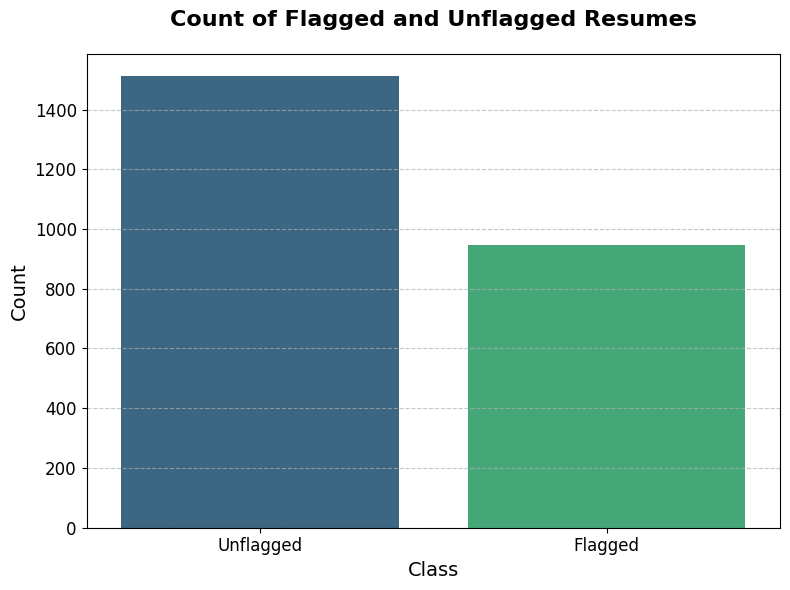

In [ ]:
# Plotting the distribution of Flagged and Unflagged classes
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=resume_df, palette='viridis')
plt.title('Count of Flagged and Unflagged Resumes', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Unflagged', 'Flagged'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<ipython-input-9-8998e0dc7721>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


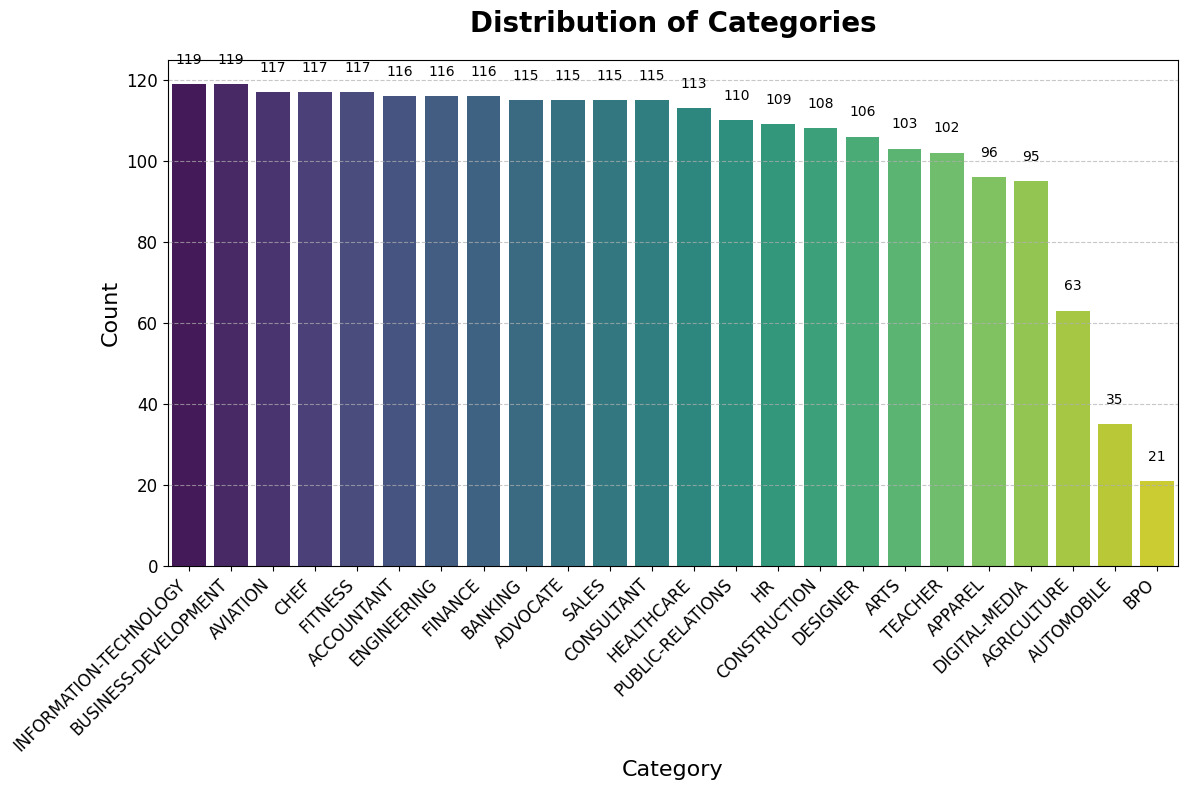

In [ ]:
# Plotting the distribution of Categories as a Bar Chart
plt.figure(figsize=(12, 8))
category_counts = resume_df['Category'].value_counts()

sns.barplot(
    x=category_counts.index,
    y=category_counts.values,
    palette='viridis'
)

# Add labels and title
plt.title('Distribution of Categories', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Category', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add annotations to the bars
for index, value in enumerate(category_counts.values):
    plt.text(index, value + 5, f'{value}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


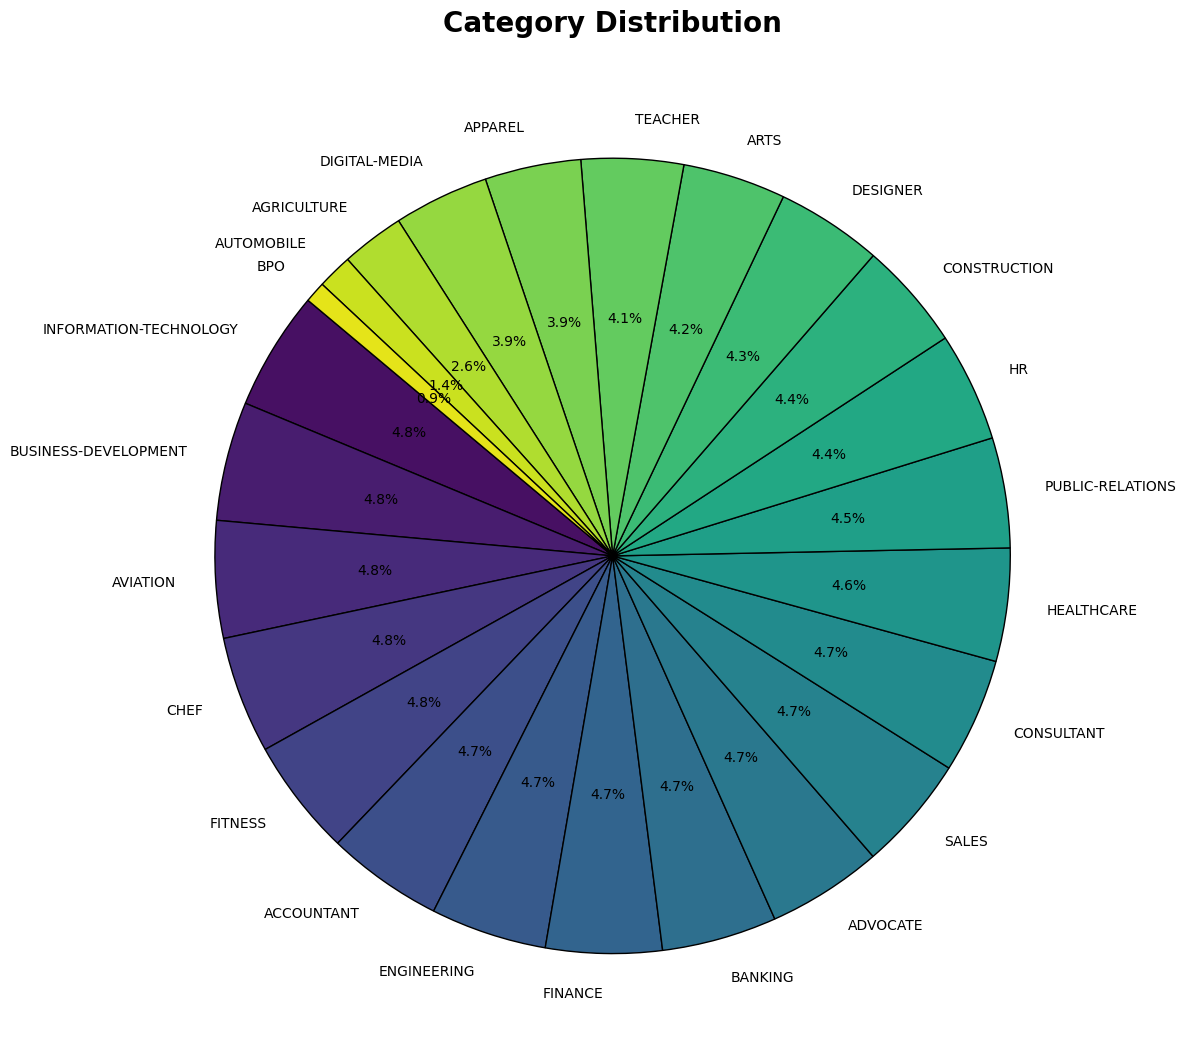

In [ ]:
# Plotting the distribution of Categories as a Pie Chart
plt.figure(figsize=(12, 12))
category_counts = resume_df['Category'].value_counts()

# Create pie chart
plt.pie(
    category_counts.values,
    labels=category_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('viridis', n_colors=len(category_counts)),
    wedgeprops={'edgecolor': 'black'}
)

# Add title
plt.title('Category Distribution', fontsize=20, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


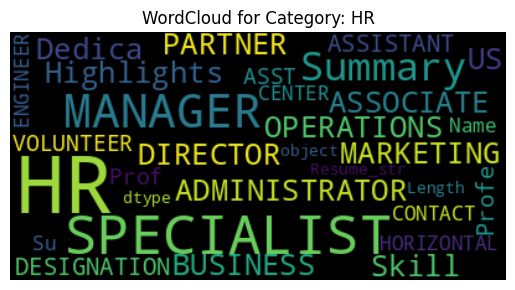

In [ ]:
# WordCloud for a specific category
category_name = 'HR'  # Example category
wc = WordCloud(max_words=2000, stopwords=WordCloud().stopwords).generate(
    str(resume_df[resume_df['Category'] == category_name]['Resume_str'])
)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title(f"WordCloud for Category: {category_name}")
plt.show()

# STEP 4: FEATURE VECTORIZATION

In [ ]:
# Apply TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(resume_df['Resume_str'])
y = resume_df['Class']


In [ ]:
# Display the feature names generated by the TF-IDF Vectorizer
feature_names = vectorizer.get_feature_names_out()
print("Sample features from TF-IDF Vectorizer:", feature_names[:20])  # Display the first 20 features


Sample features from TF-IDF Vectorizer: ['00' '000' '01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '100' '1000'
 '101' '1099' '10g' '11' '110' '11g']


# STEP 5: TRAIN-TEST SPLIT

In [ ]:
# Check for missing values in y
print("Number of NaN values in y:", y.isnull().sum())

# Drop rows with missing target values
resume_df = resume_df[~resume_df['Class'].isnull()]

# Recreate X and y
X = vectorizer.fit_transform(resume_df['Resume_str'])
y = resume_df['Class']

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Train-Test split completed successfully.")


Number of NaN values in y: 0
Train-Test split completed successfully.


# STEP 6: HANDLE IMBALANCE (SMOTE)

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())


Class distribution after SMOTE:
Class
0    1511
1    1511
Name: count, dtype: int64


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Apply undersampling
undersampler = RandomUnderSampler(random_state=42)
X_balanced, y_balanced = undersampler.fit_resample(X_resampled, y_resampled)

# Check the class distribution after undersampling
print("Class distribution after undersampling:")
print(pd.Series(y_balanced).value_counts())

# Split the undersampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)


Class distribution after undersampling:
Class
0    1511
1    1511
Name: count, dtype: int64


# STEP 7: MODEL TRAINING AND EVALUATION

Classification Report (Naive Bayes):
              precision    recall  f1-score   support

           0       0.61      0.79      0.69       320
           1       0.65      0.44      0.52       285

    accuracy                           0.62       605
   macro avg       0.63      0.61      0.61       605
weighted avg       0.63      0.62      0.61       605



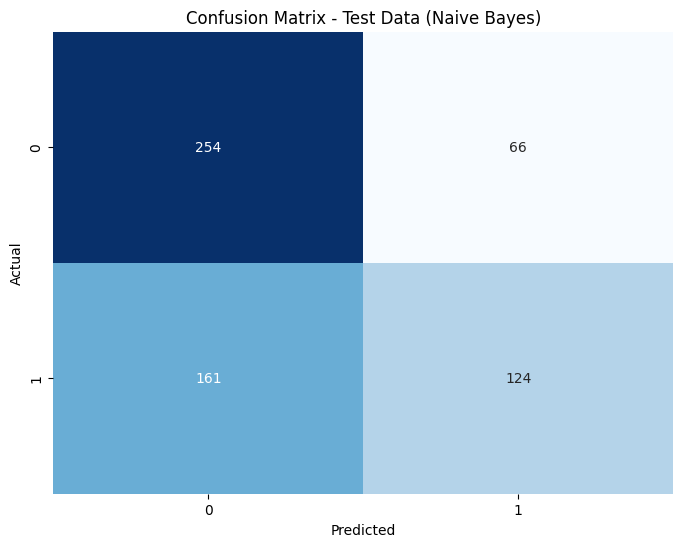

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train a Naive Bayes model on the balanced dataset
Bayes_clf = MultinomialNB(alpha=3)
Bayes_clf.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_test = Bayes_clf.predict(X_test)

# Generate and print the classification report
print("Classification Report (Naive Bayes):")
print(classification_report(y_test, y_pred_test))

# Generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - Test Data (Naive Bayes)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       320
           1       0.84      0.77      0.80       285

    accuracy                           0.82       605
   macro avg       0.83      0.82      0.82       605
weighted avg       0.82      0.82      0.82       605



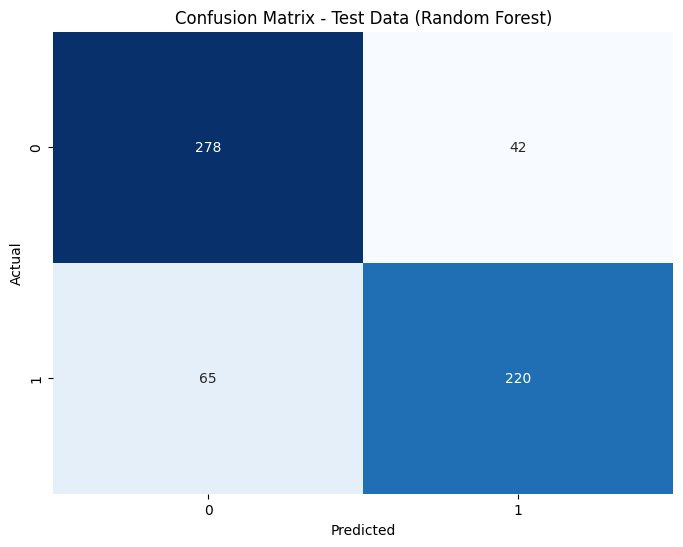

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Evaluate the Random Forest model on the test set
y_pred_test_rf = rf_clf.predict(X_test)

# Generate and print the classification report
print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_test_rf))

# Generate and plot the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_test_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - Test Data (Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
import joblib

# Save the Random Forest model
joblib.dump(rf_clf, 'random_forest_model.pkl')

# Save the vectorizer
joblib.dump(vectorizer, 'vectorizer.pkl')

print("Random Forest model and vectorizer saved successfully.")


Random Forest model and vectorizer saved successfully.


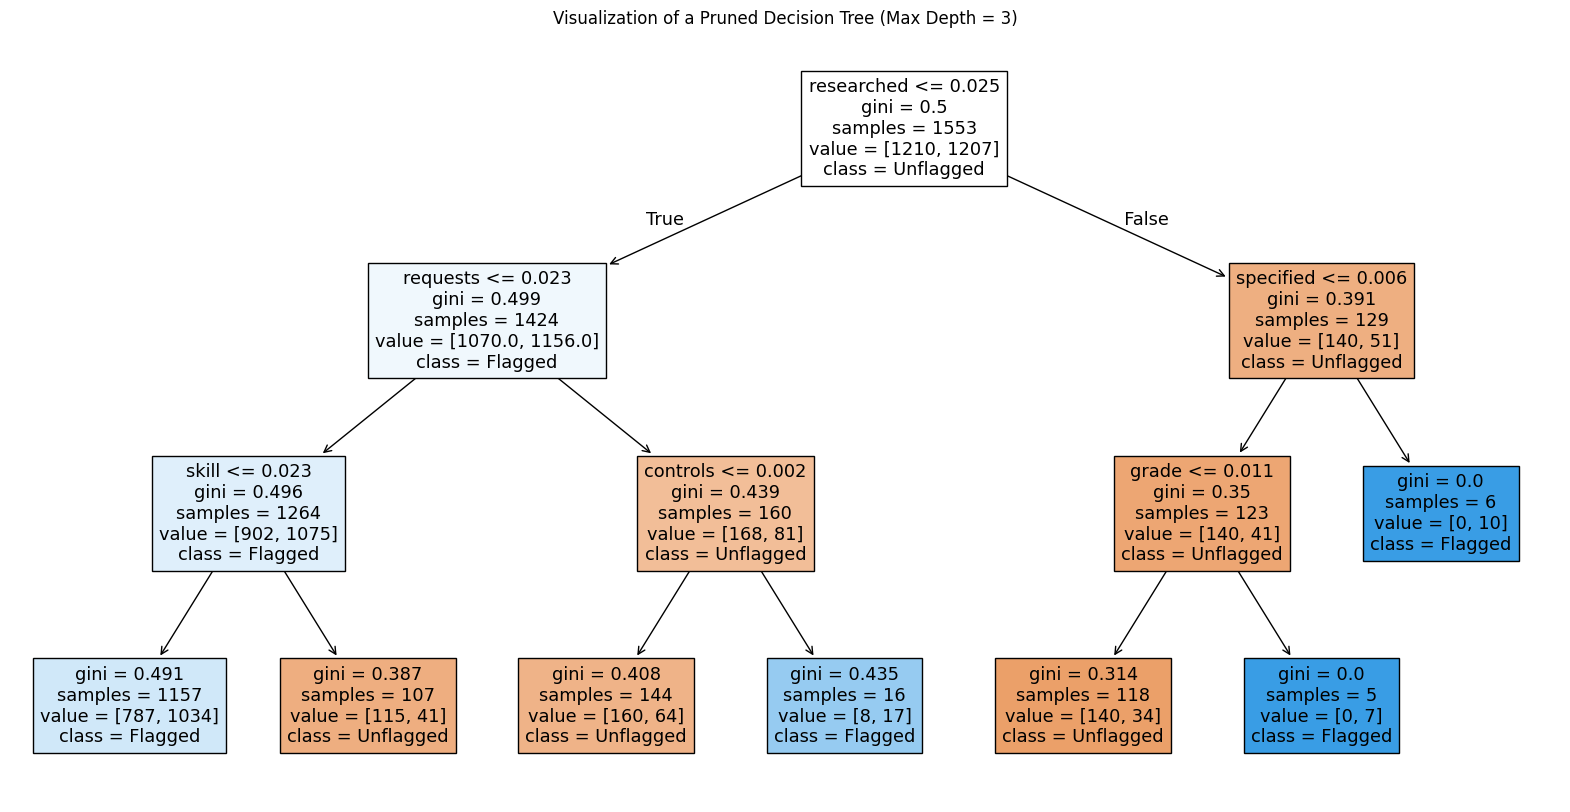

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Train a Random Forest with limited tree depth
rf_clf_pruned = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
rf_clf_pruned.fit(X_train, y_train)

# Extract a single tree from the pruned Random Forest
single_tree_pruned = rf_clf_pruned.estimators_[0]

# Visualize the pruned tree
plt.figure(figsize=(20, 10))
plot_tree(
    single_tree_pruned,
    filled=True,
    feature_names=vectorizer.get_feature_names_out(),
    class_names=["Unflagged", "Flagged"]
)
plt.title("Visualization of a Pruned Decision Tree (Max Depth = 3)")
plt.show()




# STEP 8: PREDICTION ON NEW DATA

In [ ]:
!pip install PyPDF2
import PyPDF2
from google.colab import files
import joblib

# Load the saved Random Forest model and vectorizer
rf_clf = joblib.load('random_forest_model.pkl')
vectorizer = joblib.load('vectorizer.pkl')

# Function to extract text from a PDF
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ""
        for page in reader.pages:
            text += page.extract_text()
        return text

# Function to check reasons for flagging
def check_flagging_reasons(text):
    reasons = []
    if len(text.split()) < 100:
        reasons.append("Resume is too short (less than 100 words).")
    if "lorem ipsum" in text.lower():
        reasons.append("Contains placeholder text ('lorem ipsum').")
    if "no experience" in text.lower():
        reasons.append("Mentions 'no experience'.")
    if "skills: none" in text.lower():
        reasons.append("Mentions 'Skills: None'.")
    if not any(kw in text.lower() for kw in ["experience", "skills", "education"]):
        reasons.append("Missing key sections (e.g., 'experience', 'skills', 'education').")
    return reasons

# Allow the user to upload a PDF
uploaded_pdf = files.upload()

# Extract the uploaded file name
pdf_file_name = list(uploaded_pdf.keys())[0]

# Extract text from the uploaded PDF
pdf_text = extract_text_from_pdf(pdf_file_name)

# Transform the extracted text and make a prediction
pdf_vectorized = vectorizer.transform([pdf_text])
prediction = rf_clf.predict(pdf_vectorized)

# Display the prediction result and reasons
if prediction[0] == 1:
    print("The uploaded resume is: Flagged")
    reasons = check_flagging_reasons(pdf_text)
    if reasons:
        print("Reasons for flagging:")
        for reason in reasons:
            print(f"- {reason}")
    else:
        print("No specific reasons identified, but the model flagged this resume.")
else:
    print("The uploaded resume is: Unflagged")


Saving resume (2).pdf to resume (2) (1).pdf
The uploaded resume is: Unflagged


# STEP 9: DETAILED METRICS ANALYSIS

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Naive Bayes metrics
print("Metrics for Naive Bayes Model:")

# Training dataset metrics for Naive Bayes
nb_train_accuracy = accuracy_score(y_train, Bayes_clf.predict(X_train))
nb_train_precision = precision_score(y_train, Bayes_clf.predict(X_train), zero_division=0)
nb_train_recall = recall_score(y_train, Bayes_clf.predict(X_train))
nb_train_f1 = f1_score(y_train, Bayes_clf.predict(X_train))

# Test dataset metrics for Naive Bayes
nb_test_accuracy = accuracy_score(y_test, y_pred_test)
nb_test_precision = precision_score(y_test, y_pred_test, zero_division=0)
nb_test_recall = recall_score(y_test, y_pred_test)
nb_test_f1 = f1_score(y_test, y_pred_test)

# Print Naive Bayes metrics
print("\nMetrics on Train Dataset:")
print(f"Accuracy: {nb_train_accuracy:.2f}")
print(f"Precision: {nb_train_precision:.2f}")
print(f"Recall: {nb_train_recall:.2f}")
print(f"F1-Score: {nb_train_f1:.2f}")

print("\nMetrics on Test Dataset:")
print(f"Accuracy: {nb_test_accuracy:.2f}")
print(f"Precision: {nb_test_precision:.2f}")
print(f"Recall: {nb_test_recall:.2f}")
print(f"F1-Score: {nb_test_f1:.2f}")

# Random Forest metrics
print("\nMetrics for Random Forest Model:")

# Training dataset metrics for Random Forest
rf_train_accuracy = accuracy_score(y_train, rf_clf.predict(X_train))
rf_train_precision = precision_score(y_train, rf_clf.predict(X_train), zero_division=0)
rf_train_recall = recall_score(y_train, rf_clf.predict(X_train))
rf_train_f1 = f1_score(y_train, rf_clf.predict(X_train))

# Test dataset metrics for Random Forest
rf_test_accuracy = accuracy_score(y_test, y_pred_test_rf)
rf_test_precision = precision_score(y_test, y_pred_test_rf, zero_division=0)
rf_test_recall = recall_score(y_test, y_pred_test_rf)
rf_test_f1 = f1_score(y_test, y_pred_test_rf)

# Print Random Forest metrics
print("\nMetrics on Train Dataset:")
print(f"Accuracy: {rf_train_accuracy:.2f}")
print(f"Precision: {rf_train_precision:.2f}")
print(f"Recall: {rf_train_recall:.2f}")
print(f"F1-Score: {rf_train_f1:.2f}")

print("\nMetrics on Test Dataset:")
print(f"Accuracy: {rf_test_accuracy:.2f}")
print(f"Precision: {rf_test_precision:.2f}")
print(f"Recall: {rf_test_recall:.2f}")
print(f"F1-Score: {rf_test_f1:.2f}")


Metrics for Naive Bayes Model:

Metrics on Train Dataset:
Accuracy: 0.70
Precision: 0.78
Recall: 0.58
F1-Score: 0.66

Metrics on Test Dataset:
Accuracy: 0.62
Precision: 0.65
Recall: 0.44
F1-Score: 0.52

Metrics for Random Forest Model:

Metrics on Train Dataset:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-Score: 1.00

Metrics on Test Dataset:
Accuracy: 0.82
Precision: 0.84
Recall: 0.77
F1-Score: 0.80
